# Lab Assignment Five: Evaluation and Multi-Layer Perceptron
## Rupal Sanghavi, Omar Roa, Van Tran

# Business Case

This dataset represents the responses from students and their friends(ages 15-30, henceforth stated as "young people") of a Statistics class from the Faculty of Social and Economic Sciences at The Comenius University in Bratislava, Slovakia. Their survey was a mix of various topics.

* Music preferences (19 items)
* Movie preferences (12 items)
* Hobbies & interests (32 items)
* Phobias (10 items)
* Health habits (3 items)
* Personality traits, views on life, & opinions (57 items)
* Spending habits (7 items)
* Demographics (10 items)

The dataset can be found here. https://www.kaggle.com/miroslavsabo/young-people-survey

Our target is to predict how likely a young person would have an interest in PC Software and Hardware. According to Time Magazine (http://time.com/4433964/teens-social-media-advertising/), "YouTube has become so saturated with popular vloggers that marketers are now turning to so-called "micro-influencers" with smaller but more devoted followings, while agencies are shifting their ad dollars from television to YouTube."

What is a "micro-influencer"? "A micro-influencer is usually Instafamous or a Youtube sensation with a relatively high social following who they have a great impact on." (https://www.bcsagency.com/news/step-aside-bloggers-its-time-for-micro-influencers-to-take-the-stage) According to Digiday (http://digiday.com/marketing/micro-influencers/), if a content creator with a large audience promotes a product, there is a chance that only a small subset of their audience is interested. A "micro-influencer" would likely have an audience that we mostly interested in a product placement by their trusted "micro-influencer".

PC Software and Hardware is the classifier that we chose for this project, but there are various other interests in our dataset (Socializing, Dancing, Art) that could be predicted. The point is to gauge interest in a particular topic, hire a "micro-influencer" to generate content for that topic, and include product placement.

As for how well this should perform? We weren't able to find many articles talking specifically about an algorithm to predict sales trends, but the market is certainly interested. 

* https://www.emarketer.com/Article/Marketers-Turn-Algorithms-Improve-Attribution/1014463
* https://martechtoday.com/algorithms-advertising-7-steps-introducing-ai-marketing-195037
* https://hbr.org/2015/06/the-perils-of-algorithm-based-marketing

We would at a minimum like to perform as well as SKLearn. At best we would like to perform better based on our scoring function (mentioned below), meaning consistently get lower scores.

In [3]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
%load_ext memory_profiler
from sklearn.metrics import make_scorer
from scipy.special import expit
import time
import math
import random
from memory_profiler import memory_usage
from sklearn import metrics as mt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold



from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

target_classifier = 'PC'
df = pd.read_csv('responses.csv', sep=",")

# Preparation

In [4]:
# remove rows whose target classfier value is NaN
df_cleaned_classifier = df[np.isfinite(df[target_classifier])]
# change NaN number values to the mean
df_imputed = df_cleaned_classifier.fillna(df.mean())
# get categorical features
object_features = list(df_cleaned_classifier.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [5]:
df_cleaned_classifier.isnull().sum().max()

20

In [6]:
df_fixed.shape

(1004, 173)

Our dataset (1010 rows and 150 columns) was mostly ordinal data as numbers (preferences ranked 1-5) . We also had some ordinal data as strings. 

e.g.
How much time do you spend online?: No time at all - Less than an hour a day - Few hours a day - Most of the day

We first removed any rows which contained NaN values for our target classifer, Shopping centres. Afterwards we imputed mean values for any NaN values in other features. We decided to impute due to the fact that there were not many NaN values in our features compared to the size of our data set. (At most was 20 for a feature, as shown above). We then one-hot encoded any string object, which created extra features.

We are left with numerical values for our features and a size of 1004 x 173

# Evaluation

## Metrics To Evaluate Algorithm's Generalization Performance

In [7]:
# Research on Cost Matrix
# http://www.ibm.com/support/knowledgecenter/SSEPGG_11.1.0/com.ibm.im.model.doc/c_cost_matrix.html

cost_matrix = np.matrix([[0,1,2,3,4],
[1,0,1,2,3],
[3,1,0,1,2],
[5,3,1,0,1],
[7,5,2,1,0]])

def get_confusion_costTot(confusion_matrix, cost_matrix):
    score = np.sum(confusion_matrix*cost_matrix)
    return score

We created a cost matrix with advice from IBM's Knowledge Center. We heavily weighted having a false negative due to wasting money on someone who likely would not have interest in the topic and therefore not engage with the micro-influencer. A false positive carries a higher weight than most but is still not the most severe because the money spent on a micro-influencer is still not not wasted due to their more niche topics capturing audiences.
The elements closer to a false negative are weighed heavier than the rest of the elements, which carry a weight of 1*d where d is the distance from the diagonal. We thought values with less confusion should carry less weight.
We then multiply each element in our confusion matrix by the corresponding element in the cost matrix. This means that correct predictions will have no weight, but wrong predictions will carry some weight as discussed above.
Finally, we sum the elements of the new matrix, and use that score as a way to determine performance. The lower the score, the less wrong predictions were made.

## Divide Data into Training and Testing

In [8]:
# we want to predict the X and y data as follows:
if target_classifier in df_fixed:
    y = df_fixed[target_classifier].values # get the labels we want
    del df_fixed[target_classifier] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

X = X/5
num_folds = 10

cv_object = StratifiedKFold(n_splits= num_folds, random_state=None, shuffle=True)
cv_object.split(X,y)

print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


We are using Stratified K Fold as our cross-validation object. Scikit's page states "each set contains approximately the same percentage of samples of each target class as the complete set."(http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) This is important as we want to represent the dataset as accurately as possible. Kfolds also includes all our data over the course of the folds, so we know that all our data is being used at some point.

We did not split our data into validation/train/test sets due to the fact that our data sample size is small (just over 1000 samples). We kept our data set split into training and test. 

In [9]:
for train_indices, test_indices in cv_object.split(X,y): 

        X_train = (X[train_indices])
        y_train = y[train_indices]

        X_test = (X[test_indices])
        y_test = y[test_indices]

# Modeling

In [23]:
max_iters = 300
clf = MLPClassifier(max_iter=max_iters)

In [24]:
from sklearn.ensemble import BaggingClassifier

class MyEnsemble():
    
    def __init__(self, c, num_c, max_s, v):
        self.Ensemble = BaggingClassifier(base_estimator= c,
                                    n_estimators = num_c,
                                     max_samples = max_s,
                                     verbose = v)
    def predict(self, X):
        return self.Ensemble.predict(X)
    
    def fit(self, X,y):
        self.Ensemble.fit(X,y)
        
    def fit_random(self, X, y):
        self.fit(X,y) # just to get the ensemble estimators initialized
        for classifier in self.Ensemble.estimators_:
            self.fit(X,y)
            row_indexes = np.random.randint(X.shape[0], size=self.Ensemble.max_samples) # gets row indexes
            column_indexes = np.random.randint(X.shape[1], size=math.floor(math.sqrt(X.shape[1]))) #gets column indexes
            classifier.fit(X[np.ix_(row_indexes,column_indexes)], y[row_indexes])
            
    def predict_random(self, x):
        for classifier in self.Ensemble.estimators_:
            predict(x)
    
    def predict_proba(self, X):
        return self.Ensemble.predict_proba(X)

In [25]:
num_estimators = 20

ensemble = MyEnsemble(clf, num_estimators ,y_train.shape[0],False)
ensemble.fit(X_train,y_train)
ensemble_y_hat = ensemble.predict(X_test)

print(mt.confusion_matrix(ensemble_y_hat,y_test))

[[ 2  3  1  1  0]
 [ 4  7  5  3  1]
 [ 7  7 13  7  3]
 [ 0  2  2  3  7]
 [ 0  1  4  6  9]]


In [ ]:
with np.errstate(all='ignore'):

    ensemble_random_sub_sampling = MyEnsemble(clf, num_estimators, y_train.shape[0],False)
    ensemble_random_sub_sampling.fit_random(X_train,y_train)
    r_ensemble_y_hat=ensemble_random_sub_sampling.predict(X_test)

print(mt.confusion_matrix(r_ensemble_y_hat,y_test))

/Users/Omar/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Omar/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Omar/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Omar/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/Omar/anaconda/lib/python3

In [33]:
prob_a_matrix = ensemble.predict_proba(X_test)
print(prob_a_matrix[:10, :])

[[ 0.35979033  0.45684129  0.15643407  0.0154944   0.01143991]
 [ 0.23901873  0.39069571  0.16464788  0.1900404   0.01559728]
 [ 0.13494251  0.21019192  0.44311683  0.19970751  0.01204124]
 [ 0.00217004  0.01127594  0.06511319  0.49984944  0.42159138]
 [ 0.06845033  0.14686801  0.66982822  0.08751981  0.02733364]
 [ 0.11145009  0.08742499  0.33245533  0.23658759  0.23208201]
 [ 0.13248778  0.58550616  0.19367229  0.0624954   0.02583837]
 [ 0.14631545  0.14423205  0.29559779  0.24392726  0.16992745]
 [ 0.02183088  0.08833357  0.16266689  0.52842894  0.19873972]
 [ 0.06908892  0.18350898  0.43242215  0.22899771  0.08598223]]


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 2  4  7  0  0]
 [ 3  7  7  2  1]
 [ 1  5 13  2  4]
 [ 1  3  7  3  6]
 [ 0  1  3  7  9]]


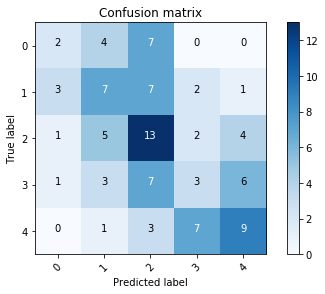

In [35]:
acc = mt.accuracy_score(y_test,ensemble_y_hat)
            #         lr_clf_accuracies.append(acc)
            #         cost_accuracies.append([acc])

ensemble_conf = mt.confusion_matrix(y_test,ensemble_y_hat)
plot_confusion_matrix(ensemble_conf, classes=[0, 1, 2, 3, 4])

Confusion matrix, without normalization
[[ 3  5  3  1  1]
 [ 5  5  4  3  3]
 [ 1  6 10  3  5]
 [ 1  3  5  4  7]
 [ 0  1  3  7  9]]


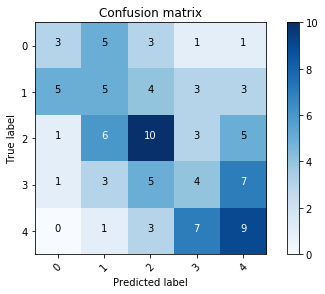

In [36]:
clf.fit(X_train, y_train)
clf_y_hat = clf.predict(X_test)
plot_confusion_matrix(mt.confusion_matrix(y_test, clf_y_hat), classes=[0, 1, 2, 3, 4])

In [37]:
ensemble_score = get_confusion_costTot(ensemble_conf, cost_matrix)
ensemble_score

909

In [38]:
total_scores = []

estimators = ensemble.Ensemble.estimators_

for estimator in estimators:
    
    estimator.fit(X_train, y_train)
    estimator_y_hat = estimator.predict(X_test)
    estimator_conf = mt.confusion_matrix(y_test, estimator_y_hat)
    score = get_confusion_costTot(estimator_conf, cost_matrix)
    total_scores.append(score)

In [39]:
print(total_scores)

[868, 939, 949, 935, 949, 956, 937, 947, 960, 927, 923, 931, 917, 964, 897, 903, 939, 923, 932, 934]


In [40]:
total_scores.append(ensemble_score)
print(total_scores)

[868, 939, 949, 935, 949, 956, 937, 947, 960, 927, 923, 931, 917, 964, 897, 903, 939, 923, 932, 934, 909]


In [ ]:
names = ('MLP1', 'MLP2', 'MLP3', 'MLP4', 'MLP5', 'MLP6', 'MLP7', 'MLP8', 'MLP9' ,'MLP10', "OUR_Ensemble")
yticks = [1,2,3,4,5,6,7,8,9,10,11]
xticks = [0,100,200,300,400,500,600,700,800,900]

fig = plt.figure()
plt.barh(yticks, total_scores, 0.4)

plt.xlabel('Scores')
plt.ylabel('Classifier')
plt.yticks(yticks, names)
plt.xticks(xticks)
plt.title("Ensemble vs Classifier Scores")